In [1]:
# If you are reading this notebook on a Binder, make sure to right-click the file name in
# the left-side file viewer and select `Open With > Notebook` to view this as a notebook

# <i class="fas fa-book fa-fw"></i> Regularization: Ridge

In the last chapter on {doc}`../assessing_performance/index` we introduced the concept of *overfitting* and the importance of selecting a model of the right complexity. Our goal shifted from our first attempt at simply minimizing training error, to trying to find a model that would perform best in the future, approximated by our test error. Since we want the test error to be an unbiased estimate of the future, we had to use techniques like a validation set or cross validation to choose the best model complexity, and then test on our test set to estimate our chosen model's performance.

The major pattern we saw was that using a model that was too complex, like an extremely high degree polynomial, it had no option but to overfit if it was sufficiently complex for the data it was trained on. But what if we could change our model so that it was aware when it was overfitting and prevent that from happening? In other words, what if the model could *self-regulate* to prevent itself from overfitting. This idea of modifying the model to prevent itself from overfitting leads us to a set of techniques known as **regularization**. We will explore the ideas behind two of the most most popular regularization techniques, introducing the the background and one of the techniques in this chapter and the other in the next (TODO link).

## Background: Coefficients

```{margin}
{{ref_pipeline}}\. Note that in this code example, we use some new scikit-learn features like the [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  to more easily make a sequence of processing steps from feature extraction (polynomial features) to a regression model. This is a useful feature of scikit-learn that you can check out in more detail in the documentation.
```

From the last chapter, we have a good understanding that learned predictors that bounce around wildly like a high-degree polynomial on a small amount of data seem to be overfit. For example, if we train a 30 degree polynomial on 10 examples, we could visually see this level of overfitting in the predictions made by the model<sup>{{ref_pipeline}}</sup>.

In [2]:
# This code cell defines a helper function we use below.
# Understanding the code in this hidden cell is not important

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# Special functions for Jupyter Notebook output
from IPython.display import display, Markdown

LEGEND_PARAMS = {"facecolor": "white", "framealpha": 1}

sns.set()

# Set random seet
np.random.seed(123)


def true_f(x: float) -> float:
    """
    True function f(x) (unknown to us)
    """
    return 2 * x - 1.4 * x ** 2


def animl_generate_data(n: int) -> tuple[np.array, np.array]:
    """
    Creates and returns a DataFrame with n randomly drawn examples
    """
    Xs = np.random.uniform(0, 1, n)                # generate n numbers uniform at random from [0, 1]
    ys = true_f(Xs) + np.random.normal(0, 0.1, n)  # evaluate f at each x and add Gaussian noise (mean=0, variance=.1)
    # Need to make Xs a 2D array (with 1 column)
    return Xs.reshape(-1, 1), ys


def animl_plot_data(data: pd.DataFrame, x: str, y: str) -> None:
    fig, ax = plt.subplots(1)
    sns.scatterplot(data=data, x=x, y=y, color="black", alpha=0.9, ax=ax, label="Data")

    ax.set_title("Relating Living Room Square Footage to House Price")
    ax.legend(**LEGEND_PARAMS)


def animl_plot_regression(Xs: np.array, targets: np.array,
                          model: LinearRegression) -> None:
    fig, ax = plt.subplots(1)

    # Plot predictor
    min_x, max_x = Xs.min(), Xs.max()
    plot_xs = np.linspace(min_x, max_x, num=100)
    pred_ys = model.predict(plot_xs.reshape(-1, 1))
    ax.plot(plot_xs, pred_ys, color="#59C5E6", linewidth=2, label="Predictor")

    # Plot data
    sns.scatterplot(x=Xs[:, 0], y=targets, ax=ax, color="black", label="Data")

    # Customize plot
    y_min, y_max = targets.min(), targets.max()
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    ax.set_title("Predicting Price (dollars) with Living Room size (sq. ft.)")
    ax.legend(**LEGEND_PARAMS)

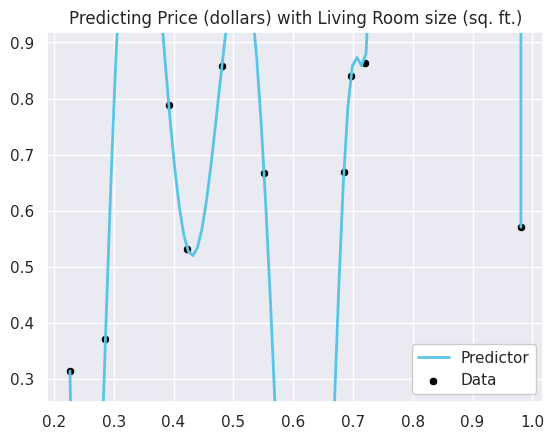

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def overfitting_experiment(n: int, degree: int, plot: bool=True) -> LinearRegression:
    """
    Runs an experiment generating a polynomial model trained on
    n points generated randomly. Plots the model predictions compared
    to the training data. Returns the model afterward.
    """

    Xs, ys = animl_generate_data(n)

    # We use a new construct from scikit-learn called Pipeline to make
    # a sequence of preproccessing steps. First to transform the data to
    # have polynomial features, then to train a linear regression model.
    # We can call fit/predict on this pipeline and it runs each step
    # in sequence (first transform features, then to linear regression model)
    model = Pipeline([
        ("features", PolynomialFeatures(degree)),
        ("linear model", LinearRegression())
    ])
    model.fit(Xs, ys)

    # Plot predictions
    if plot:
        animl_plot_regression(Xs, ys, model)
    return model

model_small_data = overfitting_experiment(n=10, degree=30)

However, if we instead had a lot more data we don't see the same overfitting behavior visually even with a model of the same complexity.

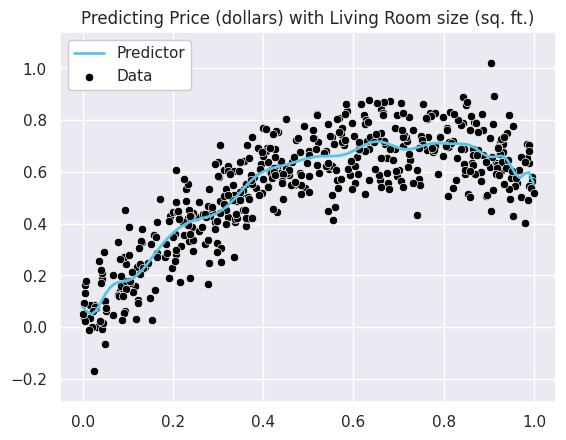

In [4]:
model_large_data = overfitting_experiment(n=500, degree=30)

```{margin}
{{ref_coefficients}}\. Note this is a general statement and not saying the coefficients strictly increase. You can see in this graph that the magnitude of the largest coefficients isn't monotonically increasing. This is for a few reasons:

1. Numbers in Python can only be *so large* (finite memory)
2. As we increase the degree of feature polynomials, the numbers of these features is quite large so the coefficients don't have to be quite as large to compensate (more on this later)

But this trend is still generally true, that for these high degree polynomials, we tend to get large coefficients when they are overfitting. Some of these coefficients are orders of magnitude larger than the coefficients of the simple, linear models.
```

So while we can easily spot the differences in these models with our eyes, there is another method for being able to spot overfitting. It turns out that the *magnitude of the coefficients* for these very "wiggly" functions, tend to be quite large. In other words, this wiggling happens generally because the learned coefficients tend to be very large in magnitude. For example, look at what happens to the highest magnitude (largest in absolute value) coefficients for our polynomial regression model, as we increase the polynomial features<sup>{{ref_coefficients}}.

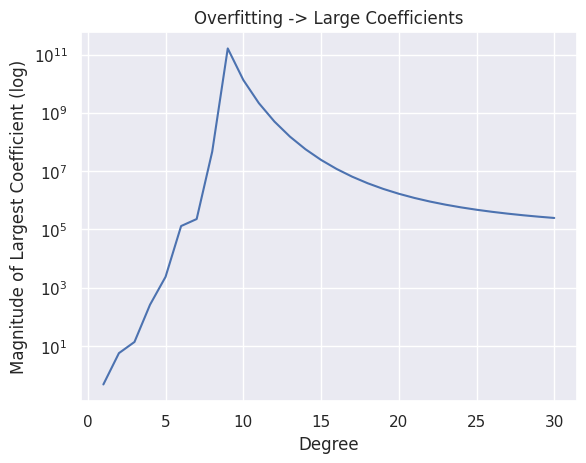

In [5]:
MAX_DEGREE = 30

Xs, ys = animl_generate_data(10)

degrees = list(range(1, MAX_DEGREE + 1))
largest_coeffs = []
for p in degrees:
    # Generate data with polynomial features of degree p
    poly_features = PolynomialFeatures(p)
    X_poly = poly_features.fit_transform(Xs)

    # Train the model
    model = LinearRegression()
    model.fit(X_poly, ys)

    # Find largest coefficient
    coeff = (np.abs(model.coef_) ** 2).sum()
    largest_coeffs.append(coeff)

# Plot the coefficients
plt.plot(degrees, largest_coeffs)
plt.title('Overfitting -> Large Coefficients')
plt.xlabel('Degree')
plt.ylabel('Magnitude of Largest Coefficient (log)')
plt.yscale('log')

So in short, having coefficients with very large magnitudes is a symptom that our model might be overfitting. So one idea to prevent overfitting, is to control the magnitude of these coefficients to make sure they aren't too large! The major idea of **regularization** is changing our model to be aware and stop itself from making its coefficients too large.

## Regularization

TODO ML pipeline image

!!!tip
    Big Idea: Change our *quality metric* to increase the cost of a model when its coefficients are getting large

Before, we trained our regression model by finding the parameters that minimized some loss function $L(w)$ (e..g, $MSE(w)$). The idea here was by minimizing the error on our training set, we were hopefully find the "best" model.

$$\hat{w} = \argmin{w} L(w)$$

But as we've discussed, training error is not the only thing to care about. So, we could imagine modifying our quality metric to not just care about error, but to also factor in other notions such as the magnitude of the coefficients. Let's assume we have some function $R(w)$ to describe the magnitude of our coefficients (more on what this function will be in a bit). We can then modify our quality metric to balance these two functions. The $\lambda$ value is there to act as a weighting between these two notions of cost (error and magnitude); more on how to choose $\lambda$ later.

$$\hat{w} = \argmin{w} L(w) + \lambda R(w)$$

The main idea here now is when we are optimizing for coefficients, it's not just the lowest error coefficients, but the ones that minimize some combination of error and cost from having high magnitude. $\lambda$ is a weighting parameter between these two cost functions. When $\lambda$ is small, we care more about the error term $L(w)$ in our optimization. When $\lambda$ is large, we care more about the magnitude term $R(w)$ in our optimization. $\lambda$ is called a **regularization hyperparameter**.

Before discussing $\lambda$ in detail, let's discuss specific choices of this $R(w)$ function to measure magnitude.

## $R(w)$ Measuring Magnitude

```{margin}
{{ref_quality_metric}}\. Recall, the quality metric defines what is "best". A different quality metric will, by definition, change which predictor we consider is the "best" one.
```

This $R(w)$ function is supposed to take all of our coefficients and return a number summarizing their overall magnitude. We call this $R$ function the **regularizer** or **regularization cost**.

Just like almost everything else we will see in this book on machine learning, how we define the magnitude of our models coefficients is yet another *modeling choice*. Choosing a different measurement of magnitude will result in different properties of which learned predictor will be considered the "best"<sup>{{ref_quality_metric}}</sup>.

### Idea 1: Sum of Coefficients

The most intuitive idea that we can imagine to describe the magnitude of all of our coefficients is to simply just sum them up.

$$R(w) = \sum_{j=1}^D w_j$$

While this notion of a regularizer seems intuitive and straightforward, it won't quite work 😞. Because we are just adding up the coefficients, we will run into the problem of coefficients with differing signs "cancelling each other out". So in a model where $w_1 = 1,000,000,000$ and $w_2 = -1,000,000,000$, $R(w) = 0$ indicating the coefficients have small magnitude, when in fact, they are quite large. So while this is on the right track, it's not quite there.

### Idea 2: Sum of Absolute Coefficients

A simple modification to the last idea to fix the major problem with it is to take the absolute values of the coefficients instead.

$$R(w) = \sum_{j=1}^D \lvert w_j \rvert$$

```{margin}
{{ref_norm_soon}}\. More on this terminology and notation at the end of this section.
```
This now solves the problem with our first idea since there is no longer any "cancelling out". This regularizer is actually quite popular in practice and is often called the **LASSO regularizer** or regularizing with the **L1 Norm**<sup>{{ref_norm_soon}}</sup>. We will discuss this regularizer in detail in the next chapter (TODO link). This regularizer is popular enough that it gets its own notation

$$R_{lasso}(w) = \lVert w \rVert_1^1$$

### Idea 3: Sum of Squared Coefficients

Similar to the last idea, another way to avoid coefficients "cancelling out," is to square the coefficients instead of taking the absolute value

$$R(w) = \sum_{j=1}^D w_j^2$$

This regularizer is called the **Ridge regularizer** or regularizing with the **L2 Norm**. Like the last regularizer, it also has its own common notation

$$R_{ridge}(w) = \lVert w \rVert_2^2$$

We will spend the rest of this chapter discussing the Ridge regularizer and the impacts of regularization on our model.

```{admonition} Aside: p-norms
There is a common set of terminology and notation for measuring the magnitude of an array/vector of numbers called the **norm**. The norm is a generalized notion of magnitude of a collection of numbers, and a common set of these norms are called **p-norms**. A p-norm is defined as

$$\lVert w \rVert_p^p = \sum_{j=1}^D \lvert w_j \rvert^p$$

or written in the equivalent form

$$\lVert w \rVert_p = \sqrt[p]{\sum_{j=1}^D \lvert w_j \rvert^p}$$

The intuition is to measure the "length" (magnitude) of a vector of numbers. Two of the most common p-norms are the L1 norm ($p=1$) and L2 norm ($p=2$). You can define p-norms for many different values of $p$, but these are by far the most common instances.
```

## Ridge Regression

**Ridge Regression** is the name of a regularized regression model that penalizes the learned parameters from being to large by including the L2 norm in the quality metric. Our goal in Ridge Regression is to optimize the following function.

$$\hat{w}_{ridge} = \argmin{w} MSE(w) + \lambda \lVert w \rVert_2^2$$

All of the other steps of our modeling task (how we do feature extraction, how we optimize this function with a method such as gradient descent, etc.) can stay the same. If we just change this quality metric, a new set of coefficients will be considered "best" and our hope is that learned predictor avoids overfitting. This all depends on this choice of $\lambda$ though.

$\lambda$ is a tuning **hyperparameter**. A hyperparameter is a value you, the ML practitioner, decides as part of your modelling step. A hyperparameter is different than the parameters learned by the learning algorithm. You the human chooses the setting of this hyperparameter, and then the corresponding model uses that settings to find the optimal parameters (i.e., coefficients). Depending on how you set the hyperparameter $\lambda$, which set of parameters (i.e., coefficients) that are "best" will be different. Let's consider two extreme cases.

* Suppose we set $\lambda = 0$. In this case, with $\lambda = 0$ our quality metric reduces to our earlier metric based purely on error. This original setting without regularization is also called **Ordinary Least Squares** (OLS). So with $\lambda = 0$ we are back to our original setting and if we are using a sufficiently complex set of features, we are likely to overfit.

$$\hat{w}_{OLS} = \argmin{w} MSE(w)$$

```{margin}
{{ref_infinity}}\. Math people: Don't chirp at us for treating $\infty$ as a number. You can make this more precise by talking about limits, but that's not the point here 💁‍♀️
```
* In the other extreme, imagine we make $\lambda$ very very large, in the extreme setting it to some number that is infinitely large<sup>{{ref_infinity}}</sup> $\lambda = \infty$. In this extreme, because we are multiplying the regularizer magnitude by such a large number, it will dominate the error term. No matter how much error your model makes, if you are multiplying the regularizer term by a SUPER large number, that error won't make a huge difference in the objective function. Concretely, with this large lambda term, we will effectively be only optimizing the following function. Again, we are imagining that $\lambda$ is so large that it drowns out the MSE term.

  $$\hat{w} = \argmin{w} \lambda \lVert w \rVert_2^2$$

  With this objective function, the *only* acceptable solution is $\hat{w} = [0, ..., 0]$ (all coefficients 0). If any of the coefficients are non-zero, then $R(w) > 0$ and then we incur $\infty \cdot R(w)$ cost; this cost would then be $\infty$. But if all the coefficients are 0, then the cost of $\infty \cdot 0 = 0$ so this is our "optimal" setting of parameters.

These are two extremes though, you wouldn't actually set $\lambda$ to be that large. In practice, you will choose some finite $\lambda$, with larger choices of $\lambda$ penalizing the coefficients for being large more, causing the coefficients to shrink. So in practice, your coefficients will have the following property

$$0 \leq \lVert w_{ridge} \rVert_2^2 \leq \lVert w_{OLS} \rVert_2^2$$

We can also visually observe how the coefficients change with respect to $\lambda$. The following graph shows the *coefficient path* for a Ridge regression model. The x-axis shows various settings of $\lambda$ from low to high and the y-axis shows the coefficient value. Each of the curves is the coefficient for a feature in our housing price model. As you increase $\lambda$ the magnitude of the coefficients goes down towards 0, empirically showing the trend we discussed above.

![Coefficient path for a ridge regression model. Explained in last paragraph.](./ridge_path.png)

So now we have a better understanding of how the choice of $\lambda$ affects the learned parameters, our next step is discussing how to choose the right value of $\lambda$. Before starting that discussion, let's test our understanding of how $\lambda$ affects the model's complexity. In the following questions, assume we are using a sufficiently complex model that is prone to overfitting before adding regularization.

In [6]:
questions = [
    {
        "question": r"""Consider setting $\lambda = 0$. Select the properties that our learned predictor is likely to exhibit.""",
        "type": "many_choice",
        "answers": [
            {
                "answer": "Low Bias",
                "correct": True,
                "feedback": "Correct! When $\lambda = 0$, we are not penalizing the model coefficients at all permits the model to overfit (large coefficients). When the model is very complex, we saw that it ends to have low bias"
            },
            {
                "answer": "High Bias",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "Low Variance",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "High Variance",
                "correct": True,
                "feedback": "Correct! When $\lambda = 0$, we are not penalizing the model coefficients at all permits the model to overfit (large coefficients). When the model is very complex, we saw that it ends to have high variance"
            }
        ]
    },
    {
        "question": r"""Consider setting $\lambda = \infty$. Select the properties that our learned predictor is likely to exhibit.""",
        "type": "many_choice",
        "answers": [
            {
                "answer": "Low Bias",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "High Bias",
                "correct": True,
                "feedback": "Correct! When $\lambda = \infty$, we are penalizing the model a ton for having any non-zero coefficients. That means the learned predictor will have all 0 coefficients; this is an extremely simple model. When the model is very simple, we saw that it ends to have high bias"
            },
            {
                "answer": "Low Variance",
                "correct": True,
                "feedback": "Correct! When $\lambda = \infty$, we are penalizing the model a ton for having any non-zero coefficients. That means the learned predictor will have all 0 coefficients; this is an extremely simple model. When the model is very simple, we saw that it ends to have low variance"
            },
            {
                "answer": "High Variance",
                "correct": False,
                "feedback": "Not quite."
            }
        ]
    },
]

from jupyterquiz import display_quiz
display_quiz(questions, shuffle_answers=False)

<IPython.core.display.Javascript object>

## Choosing $\lambda$

With an understanding of the theoretical background of regularization, and how the choice of $\lambda$ will impact our model, we will now discuss the procedure for choosing the right $\lambda$ for your model. We will see a lot of similarities to the procedures we discussed in the last chapter on {doc}`../assessing_performance/index`.

So in this setup, we will try many possible settings of the regularization hyperparameter $\lambda_i$. For each one, we will optimize the ridge regression quality metric

$$\hat{w}_{\lambda_i} = \argmin{w} MSE(w) + \lambda_i \lVert w \rVert_2^2$$

In [7]:
questions = [
    {
        "question": r"""How do we choose the best $\lambda_i$?""",
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "Pick the $\lambda_i$ that has the smallest $MSE(\hat{w}_{\lambda_i})$ on the train set",
                "correct": False,
                "feedback": "Not quite. Recall if we choose the model complexity based on training data, we would favor complex models."
            },
            {
                "answer": "Pick the $\lambda_i$ that has the smallest $MSE(\hat{w}_{\lambda_i})$ on the validation set",
                "correct": True,
                "feedback": "That's right! We want to choose the model that will perform the best in the future, so we want to choose the one with the lowest validation error. We don't need to include the regularizer term when validating our models, that's just part of the training quality metric to avoid overfitting"
            },
            {
                "answer": "Pick the $\lambda_i$ that has the smallest $MSE(\hat{w}_{\lambda_i})$ on the test set",
                "correct": False,
                "feedback": "Not quite. Recall if we choose the model complexity based on test data, you now ruin the test error as an unbiased stand in for the future."
            },
            {
                "answer": "Pick the $\lambda_i$ that has the smallest $MSE(\hat{w}_{\lambda_i}) + \lambda_i\Vert w \Vert_2^2$ on the train set",
                "correct": False,
                "feedback": "Not quite. We only modify our training quality metric with the regularizer term. When comparing models of different complexities, we just care about finding which model will perform best. One intuition for this is if we include the regularizer term across models with different settings of $\lambda$, the 'units' of these numbers are different since some models score would be more/less affected by the magnitude of their coefficients. Again, we just add the regularizer when *training* our model, but just care about its raw performance on future data."
            },
            {
                "answer": "Pick the $\lambda_i$ that has the smallest $MSE(\hat{w}_{\lambda_i}) + \lambda_i\Vert w \Vert_2^2$ on the validation set",
                "correct": False,
                "feedback": "Not quite. We only modify our training quality metric with the regularizer term. When comparing models of different complexities, we just care about finding which model will perform best. One intuition for this is if we include the regularizer term across models with different settings of $\lambda$, the 'units' of these numbers are different since some models score would be more/less affected by the magnitude of their coefficients. Again, we just add the regularizer when *training* our model, but just care about its raw performance on future data."
            },
            {
                "answer": "Pick the $\lambda_i$ that has the smallest $MSE(\hat{w}_{\lambda_i}) + \lambda_i\Vert w \Vert_2^2$ on the test set",
                "correct": False,
                "feedback": "Not quite. We only modify our training quality metric with the regularizer term. When comparing models of different complexities, we just care about finding which model will perform best. One intuition for this is if we include the regularizer term across models with different settings of $\lambda$, the 'units' of these numbers are different since some models score would be more/less affected by the magnitude of their coefficients. Again, we just add the regularizer when *training* our model, but just care about its raw performance on future data."
            }

        ]
    }
]

from jupyterquiz import display_quiz
display_quiz(questions, shuffle_answers=False)

<IPython.core.display.Javascript object>

Importantly, the regularizer is *only* used in the training phase to help our model prevent itself from overfitting while its training. After we learn our coefficients $\hat{w}$, we must treat them like coefficients we learned to make predictions $\hat{y} = \hat{w}^T x$. We don't add the regularizer term to our predictions, or our assessment of errors since it's just a mechanism to prevent our coefficients learned from overfitting. To repeat for emphasis, we generally don't use regularization when making predictions, just when training.

```{prf:algorithm} Choose regularization hyperparameter $\lambda$
:label: choose-lambda

1. **train, test, validation** = split_data(**dataset**)
2. for $\lambda$ in $\lambda s$:
    1. Train a model using Gradient Descent to minimize
       $\hat{w}_{ridge,lambda} = \argmin{w} MSE_{train}(w) + \lambda \lVert w \rVert_2^2$
    2. Compute validation error $error_{val} = MSE_{val}(\hat{w}_{ridge,\lambda})$
    3. Track $\lambda$ with smallest $error_{val}$
3. Return $\lambda^*$ and estimate future error on $MSE_{test}(\hat{w}_{ridge,\lambda^*})$
```

## Regularization Practicalities

That's pretty much it for regularization, and in particular, Ridge Regression. We can prevent overfitting by modifying our quality metric to penalize parameters that get too large (a sign of overfitting). We can control how much we penalize large coefficients by choosing our tuning parameter $\lambda$: A small $\lambda$ prefers complex models (little penalty of large coefficients) while a larger $\lambda$ prefers simple models (high penalty for large coefficients).

$$\hat{w}_{ridge} = \argmin{w} MSE_{train}(w) + \lambda \lVert w \rVert_2^2$$

However, there are a couple of details we have to clarify to modify our approach to make it work in practice.

### The Intercept

For most parameters, it makes sense to control their magnitude to prevent overfitting. However, there is one parameter where the doesn't make sense: *the intercept term* $w_0$ (assuming 0 is the index for the intercept).

Recall the intercept $w_0$ is the predicted output for an input with all features being 0. This is the "baseline" prediction in a sense. That means this intercept will be large in magnitude generally in the units for the labels are large. If most prices of homes are greater than $200k, we would expect the intercept term to be quite large even in simple models.

All of our examples above have been slightly incorrect that they didn't handle the intercept term specially. There are two main approaches to avoid penalizing large intercept terms:

* Change the regularizer function to ignore the intercept. In other words, separate the intercept coefficient $w_0$ from the remaining coefficients $w_{rest}$ (i.e., all parameters except the intercept). Then our ridge regression optimization metric is

  $$\hat{w}_0, \hat{w}_{rest} = \argmin{w_0, w_{rest}} MSE(w_0, w_{rest}) + \lambda \lVert w_{rest} \rVert_2^2$$

* Center the $y$ values beforehand so they have mean 0. This then avoids unnecessarily penalizing the $w_0$ term based on the scale of the $y$s (now the default is near 0, regardless of the scale of the original units).

### Feature Scales

A notion of scaling also affects our ridge model, but in particular, we are also considered with the scale of the *features* of our model.

Consider our simple linear model to predict the price of a house only using the square footage as a feature.

$$\hat{y} = \hat{w}_0 + \hat{w}_1 \cdot \text{sq. ft.}$$

Now with the same model, how do you think the learned coefficient $\hat{w}_1$ would change based on which unit to represent the area of a house? What if we represented area as square *miles* instead of square feet? How would a change in the scale of the data change our learned predictor?

In [8]:
questions = [
    {
        "question": r"""How would a predictor's coefficient $\hat{w}_1$ change if we change the scale of the features from square feet to square miles?""",
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "$\hat{w}_1$ in the new predictor with square miles as a feature would be larger",
                "correct": True,
                "feedback": "Correct! By making the feature units square miles, all of the feature values will get smaller. Because the price of the houses stays the same, we need a larger coefficient to make up for a smaller change in area from house to house. As a concrete example, unrelated to houses, if we learn a slope of 2 when the input is measured in inches, then switching to feet means our slope now needs to be 24 to account for the smaller feature values. "
            },
            {
                "answer": "$\hat{w}_1$ in the new predictor with square miles as a feature would be smaller",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "$\hat{w}_1$ in the new predictor with square miles as a feature would be unchanged",
                "correct": False,
                "feedback": "Not quite."
            },

        ]
    }
]

from jupyterquiz import display_quiz
display_quiz(questions, shuffle_answers=False)

<IPython.core.display.Javascript object>

This means that our current setup is penalizing coefficients associated with features that take on small values. Those coefficients need to naturally be larger to compensate for the smaller values of the data.

Thankfully, an easy fix to this problem is to make sure all of our features are on the same scale. To do this, we need to scale each of our features individually so they are in (approximately) the same range of values. A common process is to **normalize** the features so each feature has mean 0 and standard deviation 1. We use $\tilde{h}_j(x)$ to be the normalized version of $h_j(x)$.

$$\tilde{h}_j(x_i) = \frac{h_j(x_i) - \mu_j(x_1, ..., x_N)}{\sigma_j(x_1, ..., x_N)}$$

Where:
* $x_1, ..., x_N$ is the $N$ *training points*
* $\mu_j(x_1, ..., x_N) = \frac{1}{N}\sum_{i=1}^N h_j(x_i)$ is the mean of feature $j$ in the training data
* $\sigma(x_1, ..., x_N) = \sqrt{\frac{1}{N}\sum_{i=1}^N \left( h_j(x_i) - \mu_j(x_1, ..., x_N)\right)^2}$ is the standard deviation of feature $j$ in the training data

By doing this procedure, we now have that our features are all on the same 0-mean, standard-deviation-1 scale. Now we don't have to worry about penalizing a coefficient being larger because its accommodating for smaller scaled values than other features.

```{admonition} **Important** Scale based on training data always
:class: tip

One technicality that is pretty important is being careful which dataset you use to scale your features. You should do feature scaling *after* splitting your data into training, validation, test. After splitting up your data, naturally you will scale the features of your training data by the means/standard deviations in the training data. Importantly, you also need to scale your validation and test data with the mean and standard deviation **of the training data**. To repeat, always use the statistics of the **training set** to scale the training set, the validation set, the test set, and all future data.

The reason for this is the model is trained only on the training data. All scaling we do needs to be with respect to the distributions in the training data. While we hope that the training data has the same distribution of the validation/test datasets and all future data, that's not a guarantee. We need to make sure that if the future data has, for example, square footages much larger than our training set, then our scaling with respect to training data will show that those houses have larger square footages.
```

## Recap

In this chapter, we introduced the important idea of adding regularization to our training quality metric to prevent overfitting. Important concepts from this chapter include:

* How overfitting affects the magnitude of our coefficients, namely, how overfit models tend to have large coefficients
* The concept of a regularizer $R(w)$ being added to our quality metric to penalize predictors with large coefficients
* Ridge Regression using the specific regularizer of the L2 Norm of the coefficients $R(w) = \lVert w \rVert_2^2$
* The relationship between the choice of hyperparameter $\lambda$ and model complexity
* How to choose $\lambda$
* Practicalities relating to not penalizing the intercept term $w_0$ and normalizing features to be on the same scale.

## Practice

In [9]:
questions = [
    {
        "question": r"""Select all of the following statements that are true. Increasing $\lambda$ in Ridge Regression tends to lead to:""",
        "type": "many_choice",
        "answers": [
            {
                "answer": "Learned coefficients with smaller magnitudes",
                "correct": True,
                "feedback": "As we discussed how increasing $\lambda$ penalizes larger coefficients making them smaller to prevent overfitting."
            },
            {
                "answer": "Decreases the bias of the predictor",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "Increases the bias of the predictor",
                "correct": True,
                "feedback": "Increasing $\lambda$ tends to add bias to the model."
            },
            {
                "answer": "Decreases the variance of the predictor",
                "correct": True,
                "feedback": "Increasing $\lambda$ tends to add bias to the model, which generally comes with a decrease in variance"
            },
            {
                "answer": "Increases the variance of the predictor",
                "correct": False,
                "feedback": "Not quite"
            },
            {
                "answer": "Increases the training error of the learned predictor when compared to an unregularized model.",
                "correct": True,
                "feedback": "Many people find that this option being true to be surprising, but remember the point of regularization was to prevent overfitting. So if you want to prevent overfitting, you will need to find a model that generally has a higher training error compared to an overfit one."
            },
        ]
    },
    {
        "question": r"""True or False. Using the regularizer $R(w)  = \sum_{j=0}^D w_j^3$ would be effective at preventing overfitting""",
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "True",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "False",
                "correct": True,
                "feedback": "This won't work well, since cubing numbers doesn't remove sign. So it's possible for large positive coefficients to cancel out with very negative coefficients (just like with the Sum regularizer). This doesn't measure magnitude well since these signs can cancel."
            }
        ]
    },
    {
        "question": r"""Select the best option that applies. Suppose you are training a Ridge regression model for a particular task, and notice the training error (MSE) of this model is 57 while the validation error (MSE) is 32,714. Would your next step be to try a Ridge model with a larger or smaller $\lambda$?""",
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "Larger",
                "correct": True,
                "feedback": "This might suggest the case of an overfit model since it has low training error and high validation error. So if we want to investigate if it is overfitting, we might want to try a larger $\lambda$ to penalize large coefficients more to see if there is a model with better validation error."
            },
            {
                "answer": "Smaller",
                "correct": False,
                "feedback": "Not quite"
            },
            {
                "answer": "$\lambda$ shouldn't have an effect here",
                "correct": False,
                "feedback": "Not quite"
            }

        ]
    },
    {
        "question": r"""True or False. You should choose the $\lambda$ that minimizes the error on your test set""",
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "True",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "False",
                "correct": True,
                "feedback": "You should never use the test set to decide which is the appropriate model to use. You want to keep your test set to the very end to get an estimate of future error and choosing which model."
            }
        ]
    },
    {
        "question": r"""Select the best option that applies. Which of the following best describes the reason for why we include scaling features when using Ridge regression?""",
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "Scaled numbers are computationally more efficient.",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "Scaled features are easier to interpret.",
                "correct": False,
                "feedback": "Not quite."
            },
            {
                "answer": "We want to avoid penalizing the coefficient for the intercept.",
                "correct": False,
                "feedback": "Not quite. The features don't affect the intercept scale, the labels/target/outcome does"
            },
            {
                "answer": "We want to avoid overly penalizing features that take on a small scale of values (e.g., 0 to 0.01)",
                "correct": True,
                "feedback": "Features that range in small scales will tend to have larger coefficients (see our discussion on converting from sq. ft. to sq. miles). So these features might have coefficients that are naturally larger due to the scale they are working in, but would be overly penalized in regularization since we squish down large coefficients. To make sure all the coefficients are on the same scale to treat them equally, we scale the dataset for each feature"
            },
            {
                "answer": "We want to avoid overly penalizing features that take on a large scale of values (e.g., 0 to 100,000)",
                "correct": False,
                "feedback": "Not quite. Features with larger values tend to have smaller coefficients to compensate"
            },
        ]
    },
]

from jupyterquiz import display_quiz
display_quiz(questions, shuffle_answers=False)

<IPython.core.display.Javascript object>